In [1]:
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap, HeatMapWithTime
import os

In [2]:
# Plot parameters
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
inspector = inspect(engine)

In [11]:
# Determine the columns in the Measurement table
columns_measurement = inspector.get_columns("measurement")

for column in columns_measurement:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Preview the Measurement table
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Determine the columns in the Station table
columns_stn = inspector.get_columns("station")

for column in columns_stn:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Preview the Station table
engine.execute("SELECT * FROM station").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Determining the first and the last records by date

In [16]:
# Return the earliest date in the dataframe
Earliest_date = session.query(Measurement.date).order_by(Measurement.date.asc()).first()
first_date = Earliest_date[0]
first_date

'2010-01-01'

In [17]:
# Return the latest date in the dataframe
Latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
end_date = Latest_date[0]
end_date

'2017-08-23'

In [18]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(int(end_date[0:4]), int(end_date[5:7]), int(end_date[8:11])) - dt.timedelta(days = 365)
start_date = str(year_ago)
start_date

'2016-08-23'

## Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset 
no_stns = session.query(func.count(distinct(Measurement.station))).all()
print(f" There were {no_stns[0][0]} weather stations monitored in Hawaii in this study.")

 There were 9 weather stations monitored in Hawaii in this study.


In [20]:
# Merge the measurement and the station tables based on station id
sel = [Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs,
       Station.name, Station.elevation, Station.latitude, Station.longitude]

same_stn = session.query(*sel).filter(Measurement.station == Station.station).\
           all()

In [21]:
# Create a dataframe combining Measurement and Station data
df1 = pd.DataFrame(same_stn)
df1.head()

,station,date,prcp,tobs,name,elevation,latitude,longitude
0,USC00519397,2010-01-01,0.08,65.0,"WAIKIKI 717.2, HI US",3.0,21.2716,-157.8168
1,USC00519397,2010-01-02,0.00,63.0,"WAIKIKI 717.2, HI US",3.0,21.2716,-157.8168
2,USC00519397,2010-01-03,0.00,74.0,"WAIKIKI 717.2, HI US",3.0,21.2716,-157.8168
3,USC00519397,2010-01-04,0.00,76.0,"WAIKIKI 717.2, HI US",3.0,21.2716,-157.8168
4,USC00519397,2010-01-06,NaN,73.0,"WAIKIKI 717.2, HI US",3.0,21.2716,-157.8168


In [22]:
# Get averages for precipitation and observed temperature
grouped_df1 = df1.groupby("station").mean()
grouped_df1 = grouped_df1.reset_index()
grouped_df1

,station,prcp,tobs,elevation,latitude,longitude
0,USC00511918,0.047971,71.615968,0.9,21.31520,-157.99920
1,USC00513117,0.141921,72.689184,14.6,21.42340,-157.80150
2,USC00514830,0.121058,74.873297,7.0,21.52130,-157.83740
3,USC00516128,0.429988,70.915008,152.4,21.33310,-157.80250
4,USC00517948,0.063602,74.684402,11.9,21.39340,-157.97510
5,USC00518838,0.207222,72.724070,306.6,21.49920,-158.01110
6,USC00519281,0.212352,71.663781,32.9,21.45167,-157.84889
7,USC00519397,0.049020,74.553231,3.0,21.27160,-157.81680
8,USC00519523,0.114961,74.543649,19.5,21.33556,-157.71139


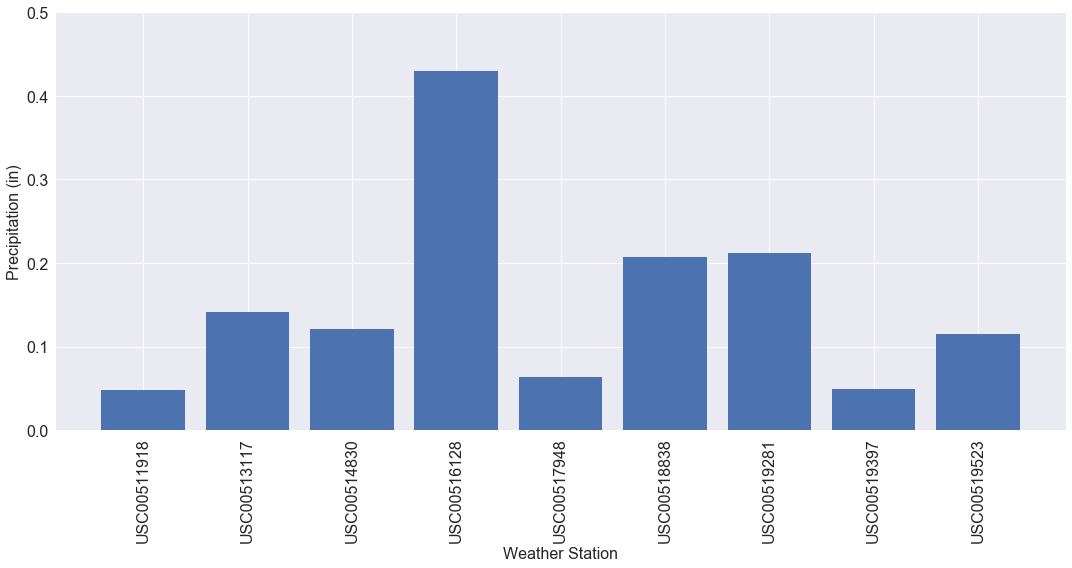

In [23]:
# Plot the average precipitation levels across the different weather stations
x = np.arange(0, len(grouped_df1))

plt.figure(figsize = (15,8))
plt.bar(x, grouped_df1["prcp"])
plt.xticks(x, grouped_df1["station"], rotation = 90)
plt.xlabel("Weather Station", fontsize = 16)
plt.ylabel("Precipitation (in)", fontsize = 16)
plt.ylim(0,0.5)
plt.tight_layout()
plt.savefig("Images/compare_precipitation.svg")

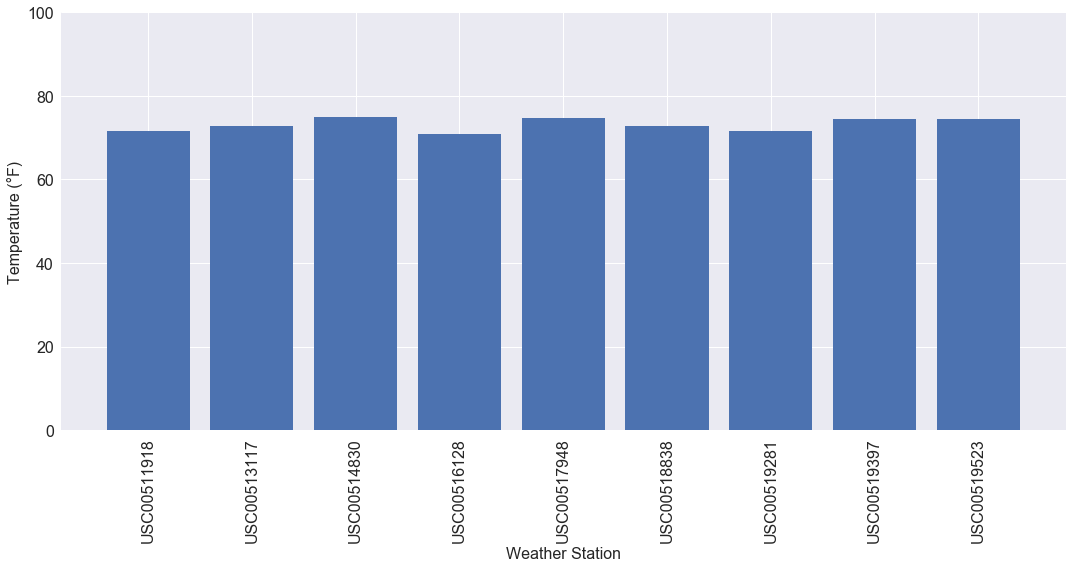

In [24]:
# Plot the average temperatures across the different weather stations
x = np.arange(0, len(grouped_df1))

plt.figure(figsize = (15,8))
plt.bar(x, grouped_df1["tobs"])
plt.xticks(x, grouped_df1["station"], rotation = 90)
plt.xlabel("Weather Station", fontsize = 16)
plt.ylabel("Temperature (°F)", fontsize = 16)
plt.ylim(0,100)
plt.tight_layout()
plt.savefig("Images/compare_temp.svg")

In [25]:
# Create lists of latitudes, longitudes, and station names
lat_lst = list(grouped_df1['latitude'])
lng_lst = list(grouped_df1['longitude'])
stn_lst = list(grouped_df1['station'])
prcp_lst = list(grouped_df1['prcp'])
tobs_lst = list(grouped_df1['tobs'])
elev_lst = list(grouped_df1['elevation'])

In [26]:
# Create map of stations

# Make an empty map
m = folium.Map(location = [21.4513, -158.0153],
               zoom_start = 10)
feature_group = folium.FeatureGroup("Locations")

# Add markers one by one on the map
for lat, lng, stn, elev in zip(lat_lst, lng_lst, stn_lst, elev_lst):
    feature_group.add_child(folium.Marker(location = [lat, lng], 
                            popup = f'Station ID: {stn}<br>Elev: {round(elev,2)}')
                           )
    
m.add_child(feature_group)
    
# Save as html
m.save("Images/markers_on_Oahu_map.html")

In [27]:
# Select the columns for the analyses
sel2 = [Measurement.station, func.count(Measurement.station)]

# What are the most active stations? (i.e. what stations have the most rows)?
stn_count = session.query(*sel2).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).\
            all()

# List the stations and the number of records
stn_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Select the most active station (most number of measurements)
most_active_stn = stn_count[0][0]
print(f"The most active station is {most_active_stn} with {stn_count[0][1]} observations "
      f"in August 2016–2017.")

The most active station is USC00519281 with 2772 observations in August 2016–2017.


In [29]:
# Calculate the minimum, average, and maximum temperature and precipitation 
# in the most active station in the last year on record
sel3 = [func.min(Measurement.prcp), func.avg(Measurement.prcp), func.max(Measurement.prcp), 
        func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

summary_weather = session.query(*sel3).filter(Measurement.station == most_active_stn).\
filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

prcp_min = round(summary_weather[0][0], 1)
prcp_avg = round(summary_weather[0][1], 1)
prcp_max = round(summary_weather[0][2], 1)
temp_min = round(summary_weather[0][3], 1)
temp_avg = round(summary_weather[0][4], 1)
temp_max = round(summary_weather[0][5], 1)

print(f"Statistics for {most_active_stn}:\n"
      f"Temp min: {temp_min} °F\n"
      f"Temp avg: {temp_avg} °F\n"
      f"Temp max: {temp_max} °F\n"
      f"Precipitation min: {prcp_min} in\n"
      f"Precipitation avg: {prcp_avg} in\n"
      f"Precipitation max: {prcp_max} in\n")

Statistics for USC00519281:
Temp min: 59.0 °F
Temp avg: 73.1 °F
Temp max: 83.0 °F
Precipitation min: 0.0 in
Precipitation avg: 0.2 in
Precipitation max: 3.0 in



## Precipitation Analysis for the last 12 months

In [ ]:
# Select the columns for the analyses
sel = [Measurement.date, Measurement.station, Measurement.prcp]

# Perform a query to retrieve the total observations and precipitation measurements
data = session.query(*sel).filter(Measurement.date > year_ago).all()

In [ ]:
data2 = session.query(Measurement).filter(Measurement.date > year_ago).all()

In [ ]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data)
df = df.sort_values("date", ascending = True) # Sort the dataframe by date
df = df.set_index("date")
df.head()

In [ ]:
# Use Pandas to calculate the summary statistics for precipitation
grouped = df.groupby("date").describe()
grouped.head()

In [ ]:
# Use the mean and the standard deviations for precipitation
pptn_df = grouped["prcp"].iloc[:, 1:3]
pptn_df.head()

In [ ]:
# Data type of the date
pptn_df.index.values.dtype

## Precipitation Plots

In [ ]:
# Date is currently set as string; need to convert to datetime and then to period format
# Resource: http://earthpy.org/time_series_analysis_with_pandas_part_2.html

pptn_df["mean"].index = pd.to_datetime(pptn_df["mean"].index) # string to datetime
pptn_df.index = pptn_df["mean"].to_period(freq = "D").index # time stamps to daily time periods
pptn_df.index

In [ ]:
# Timeseries plot by a daily frequency
pptn_df.plot(y = "mean", figsize = (15,8), legend = False)
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Average Precipitation", fontsize = 16)
plt.tight_layout()
plt.savefig("Images/pptn.svg")

In [ ]:
# Get the mean by month
pptn_df_monthly_avg = pptn_df.iloc[:, 0:1].resample("M").mean() 
pptn_df_monthly_avg.head()

In [ ]:
# Monthly precipitation averages for one year
x = np.arange(len(pptn_df_monthly_avg.index))
y = pptn_df_monthly_avg["mean"].values
plt.figure(figsize = (15,8))
plt.plot(x, y, marker = "o", markersize = 12, color = "red")

# Calculate the trendline (linear fitting)
# Resource: http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x),"b--")

# the line equation:
equation = (f"y = %.3fx + %.3f"%(z[0],z[1]))

# Plot attributes
plt.text(-0.55,0.22, equation, fontsize = 16)
plt.ylabel("Average Precipitation", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(x, pptn_df_monthly_avg.index.values, rotation = 45)
plt.tight_layout()
plt.savefig("Images/pptn_monthly_avg.svg")

In [ ]:
# Precipitation distribution
plt.figure(figsize = (15,8))
sns.distplot(pptn_df["mean"], kde = True, hist = False, rug = True,
             kde_kws = {"shade": True, "linewidth": 3},
             rug_kws = {"color": "black"})
plt.xlabel("Precipitation", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.tight_layout()
plt.savefig("Images/density_precipitation.svg")

## Temperature Analysis

In [ ]:
# Query the last 12 months of temperature observation data
tobs_12mos = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
             filter(Measurement.date >= start_date).all()

In [ ]:
# Put the list into a dataframe
df2 = pd.DataFrame(tobs_12mos)
df2 = df2.set_index("date")
df2.head()

In [ ]:
# Calculate the average temperature observed by station by day.
grouped_tobs = df2.groupby("date").describe()
grouped_tobs.head()

In [ ]:
# Extract the mean and the standard deviation from the grouped temperature observations
tobs_df = grouped_tobs["tobs"].iloc[:, 1:3]
tobs_df.head()

In [ ]:
# Determine the data type for date
tobs_df.index.values.dtype

In [ ]:
# Convert string to datetime to period
tobs_df["mean"].index = pd.to_datetime(tobs_df["mean"].index) # string to datetime
tobs_df.index = tobs_df["mean"].to_period(freq = "D").index # datetime to period
tobs_df.index

In [ ]:
# Timeseries plot by a daily frequency
tobs_df.plot(y = "mean", figsize = (15,8), legend = False)
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Temperature (°F)", fontsize = 16)
plt.tight_layout()
plt.savefig("Images/tobs.svg")

In [ ]:
# Plot the temperature in a histogram
# NB: Histograms use arbitrarily set number of bins, which affects the shape of the distribution
plt.figure(figsize = (15,8))
plt.hist(tobs_df["mean"], bins = 50, edgecolor = "black")
plt.xlabel("Temperature (°F)", fontsize = 16)
plt.ylabel("Frequency", fontsize = 16)
plt.xlim(60, 85)
plt.tight_layout()
plt.savefig("Images/hist_temp.svg")

In [ ]:
# Kernel density plot for temperature (with a rug plot)
# Resource: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
# Rug plot shows where each value in the distribution lies
plt.figure(figsize = (15,8))
sns.distplot(tobs_df["mean"], kde = True, hist = False, rug = True,
             kde_kws = {"shade": True, "linewidth": 3},
             rug_kws = {"color": "black"})
plt.xlabel("Temperature (°F)", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.tight_layout()
plt.savefig("Images/density_temp.svg")

In [ ]:
# Get the mean by month
tobs_df_monthly_avg = tobs_df.iloc[:, 0:1].resample("M").mean() 
tobs_df_monthly_avg.head()

In [ ]:
# Monthly temperature averages for one year
x = np.arange(len(tobs_df_monthly_avg.index))
y = tobs_df_monthly_avg["mean"].values
plt.figure(figsize = (15,8))
plt.plot(x, y, marker = "o", markersize = 12, color = "red")

# Plot attributes
plt.ylabel("Average Temperature(°F)", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(x, tobs_df_monthly_avg.index.values, rotation = 90)
plt.tight_layout()
plt.savefig("Images/temp_monthly_avg.svg")

In [ ]:
# Create a scatterplot matrix to show relationships among the environmental variables
sns.set(font_scale = 1.25)
g = sns.pairplot(grouped_df3, diag_kind = "kde", diag_kws = dict(shade = True))
plt.tight_layout()
plt.savefig("Images/scatter_matrix_envi.svg")

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format 
# '%Y-%m-%d' and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs)).\
                         filter(Measurement.date >= start_date).\
                         filter(Measurement.date <= end_date).all()


In [ ]:
# Temperatures during the last 12 months
summary_temps = calc_temps(start_date, end_date)

print(
    f"Temperature records during the last 12 months:\n"
    f"\nMin Temperature: {summary_temps[0][0]} °F"
    f"\nMax Temperature: {summary_temps[0][2]} °F"
    f"\nAverage Temperature: {round(summary_temps[0][1],1)} °F")

## Personal Vacation

In [ ]:
# Personal vacation dates, use while loops to make sure that entries are valid.
while True:
    print("What is the start date of your vacation? (yyyy-mm-dd)")
    vac_start = input()

    if vac_start not in list(df3["date"]):
        print("Please try again. Date is not in the list.\nFollow this format (yyyy-mm-dd): 2016-02-29\n")
    else:
        break

while True:        
    print("What is the end date of your vacation? (yyyy-mm-dd)")
    vac_end = input()
        
    if vac_end not in list(df3["date"]):
        print("Please try again. Follow this format (yyyy-mm-dd): 2016-02-29")
    else:
        break

while vac_start > vac_end:
    print("\nYour vacation cannot end before it started! Please try again.")
    
    print("What is the end date of your vacation? (yyyy-mm-dd)")
    vac_end = input()

print("Calculating....")

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
summary_vac_temps = calc_temps(vac_start, vac_end)

print(
    f"Oahu, HI temperatures during my vacation ({vac_start} to {vac_end}):\n"
    f"\nMin Temperature: {summary_vac_temps[0][0]} °F"
    f"\nMax Temperature: {summary_vac_temps[0][2]} °F"
    f"\nAverage Temperature: {round(summary_vac_temps[0][1],1)} °F")

In [ ]:
# Plot the results from your previous query as a box plot.
vacation_temp = session.query(Measurement.tobs).\
                         filter(Measurement.date >= vac_start).\
                         filter(Measurement.date <= vac_end).all()

# Create a list of temperatures recorded during the vacation period
temps = [temp[0] for temp in vacation_temp]

# Create box plot to show range of temperatures recorded during the vacation period
plt.figure(figsize = (15,8))
plt.boxplot(temps, showmeans = True)
plt.ylabel(f"Temperature (°F)", fontsize = 16)
plt.title(f"Temperature range during the vacation period, {vac_start} to {vac_end}", fontsize = 16)
plt.savefig("Images/box_temperature_vacation.svg")

In [ ]:
# Calculating total rainfall during the vacation using SQLAlchemy
sel4 = [Measurement.station, Station.name, 
        func.sum(Measurement.prcp).label("rainfall_sum"), 
        Station.elevation, Station.latitude, Station.longitude]

vac_rainfall = session.query(*sel4).filter(Measurement.station == Station.station).\
               filter(Measurement.date >= vac_start).\
               filter(Measurement.date <= vac_end).\
               group_by(Measurement.station).\
               order_by(func.sum(Measurement.prcp).desc()).all()

pd.DataFrame(vac_rainfall)

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific 
# month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).\
        filter(Measurement.date >= vac_start).\
        filter(Measurement.date <= vac_end).\
        group_by(Measurement.date).all()

# Dates contains lists of lists of tuples. There is a need to extract the values 
# inside the tuples so that the mm and dd could be placed in a list
date_range = [date[0] for date in dates]

date_range

In [ ]:
# Stip off the year and save a list of %m-%d strings
mm_dd_range = [date[5:10] for date in date_range]

mm_dd_range

In [ ]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_lst = [daily_normals(mm_dd) for mm_dd in mm_dd_range]
normals = [item[0] for item in normals_lst]
normals

In [ ]:
# Load the previous query results into a Pandas DataFrame
normal_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])

# add the `trip_dates` range as the `date` index
normal_df["date"] = pd.Series(mm_dd_range)

normal_df.head()

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
x = np.arange(0,len(normal_df))

normal_df.plot.area(stacked = False, alpha = 0.5, figsize = (15,8))
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Temperature (°F)", fontsize = 16)
plt.xticks(x, mm_dd_range, rotation = 45)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.savefig("Images/area_temp_vacation.svg")